# Fraud Detection/ Anomaly detection

In this project I will use different models to detect anomaly data, the given data is highly imbalanced. This will be the same in real life that there is only minority anomaly and fraud transactions.

## Part 1: Import data Load data

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# https://drive.google.com/file/d/1nSHP43_nz71dhVTFRo8sYfkJaDsbmCxN/view?usp=sharing

In [ ]:
# install pydrive to load data
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = "1nSHP43_nz71dhVTFRo8sYfkJaDsbmCxN"
file = drive.CreateFile({'id':id})
file.GetContentFile('IpAddress_to_Country.csv')
ipToCountry = pd.read_csv('IpAddress_to_Country.csv')
ipToCountry.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [ ]:
# https://drive.google.com/file/d/1m4idmt0cZqyRy1ld7GNv7-M-RmjCtW44/view?usp=sharing
id = "1m4idmt0cZqyRy1ld7GNv7-M-RmjCtW44"
file = drive.CreateFile({'id':id})
file.GetContentFile('imbalancedFraudDF.csv')
fraud_data = pd.read_csv('imbalancedFraudDF.csv')
fraud_data.head()


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
3,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0
4,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0


## Part 2: Data Exploration

Distribution of the data fraud and not fraud


In [ ]:
fraud_data['class'].value_counts()

0    136961
1      1415
Name: class, dtype: int64

In [ ]:
fraud_data.shape

(138376, 11)

In [ ]:
1415/138376

0.010225761692779094

Data is highly imbalanced

#### summary report from pandas_profiling

In [ ]:
!pip install pandas-profiling
import pandas_profiling
from pandas_profiling import ProfileReport

pandas_profiling.ProfileReport(fraud_data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

It seems that there is no missing values

In [ ]:
fraud_data.isna().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

#### Transform ip address to coresponding country name

In [ ]:
ipToCountry.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [ ]:
countries = []
for i in range(len(fraud_data)):
  ip = fraud_data.iloc[i,9]
  temp = ipToCountry[(ip >= ipToCountry['lower_bound_ip_address'])&(ip <= ipToCountry['upper_bound_ip_address'])]
  if len(temp) > 0:
    countries.append(temp['country'].values[0])
  else:
    countries.append('NA')
fraud_data["country"] = countries
fraud_data

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
3,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States
4,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada
...,...,...,...,...,...,...,...,...,...,...,...,...
138371,185619,2015-01-09 02:25:03,2015-01-09 02:25:04,30,AVOVPRJNLOLWD,SEO,IE,M,35,8.031690e+08,1,Canada
138372,144031,2015-07-07 15:29:10,2015-08-20 01:48:50,67,YLHYGZVPCLHLH,Ads,FireFox,M,23,3.572177e+09,1,Israel
138373,58899,2015-04-24 15:28:22,2015-07-16 01:53:25,54,ORSHWNJVUGJFE,Direct,Safari,M,23,1.374693e+08,1,United States
138374,120669,2015-04-14 13:53:32,2015-05-18 23:52:34,31,HNQOJFPCMBRQU,SEO,Chrome,M,31,7.087370e+08,1,China


## Part 3: Feature Engineering

In [ ]:
import time
fraud_data['interval_after_signup'] = (pd.to_datetime(fraud_data['purchase_time']) - pd.to_datetime(fraud_data['signup_time'])).dt.total_seconds()
fraud_data['signup_days_of_year'] = pd.to_datetime(fraud_data['signup_time']).dt.dayofyear
fraud_data["signup_seconds_of_day"] = pd.to_datetime(fraud_data['signup_time']).dt.second + pd.to_datetime(fraud_data['signup_time']).dt.minute * 60 + pd.to_datetime(fraud_data['signup_time']).dt.hour * 3600

fraud_data['purchase_days_of_year'] = pd.to_datetime(fraud_data['purchase_time']).dt.dayofyear
fraud_data["purchase_seconds_of_day"] = pd.to_datetime(fraud_data['purchase_time']).dt.second + pd.to_datetime(fraud_data['purchase_time']).dt.minute * 60 + pd.to_datetime(fraud_data['purchase_time']).dt.hour * 3600

fraud_data = fraud_data.drop(['user_id','signup_time','purchase_time'], axis=1)

In [ ]:
fraud_data.head()

,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day
0,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,55,82549,108,10031
1,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,158,74390,159,5934
2,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,492085.0,118,76405,124,50090
3,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,202,25792,252,67253
4,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada,4240931.0,141,21783,190,29114


## Part 4: Data split

In [ ]:
from sklearn.model_selection import train_test_split

y = fraud_data["class"]
X = fraud_data.drop(["class"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=421)


In [ ]:
X_train.shape

(110700, 13)

In [ ]:
y_train.shape

(110700,)

In [ ]:
X_train.head()

,purchase_value,device_id,source,browser,sex,age,ip_address,country,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day
15337,30,YXJAKXHYRGEXX,Direct,Safari,M,36,2.226373e+09,Japan,9409176.0,53,34035,162,25611
30992,15,CUIIRGETHBKPX,Ads,IE,M,25,1.994995e+09,Taiwan; Republic of China (ROC),1862622.0,118,4410,139,52632
5442,34,BXPYVDMQTGRIY,SEO,FireFox,F,31,1.422219e+09,Belgium,2419612.0,38,55582,66,55994
7768,54,NFRDWOXFVPVHH,Direct,IE,M,40,1.386104e+08,United States,9317798.0,204,5379,311,78377
27855,27,XKWRNXKSTTUFI,Direct,IE,M,24,1.862350e+09,China,10138748.0,46,8256,163,38204


#### In casse of the likeage of information

In [ ]:
# source and browser
X_train = pd.get_dummies(X_train, columns=['source', 'browser'])

X_train['sex'] = (X_train.sex == 'M').astype(int)

In [ ]:
# share of device, more device is shared more likely to be fraud.
X_train_device_id_mapping = X_train.device_id.value_counts(dropna=False)
X_train['n_dev_shared'] = X_train.device_id.map(X_train_device_id_mapping)

# share of ip
X_train_ip_address_mapping = X_train.ip_address.value_counts(dropna=False)
X_train['n_ip_shared'] = X_train.ip_address.map(X_train_ip_address_mapping)

# number of country
X_train_country_mapping = X_train.country.value_counts(dropna=False)#include counts of NaN
X_train['n_country_shared'] = X_train.country.map(X_train_country_mapping)

X_train = X_train.drop(['device_id','ip_address','country'], axis=1)

In [ ]:
X_train.head()

,purchase_value,sex,age,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,n_dev_shared,n_ip_shared,n_country_shared
15337,30,1,36,9409176.0,53,34035,162,25611,0,1,0,0,0,0,0,1,1,1,5351
30992,15,1,25,1862622.0,118,4410,139,52632,1,0,0,0,0,1,0,0,1,1,918
5442,34,0,31,2419612.0,38,55582,66,55994,0,0,1,0,1,0,0,0,1,1,298
7768,54,1,40,9317798.0,204,5379,311,78377,0,1,0,0,0,1,0,0,1,1,42372
27855,27,1,24,10138748.0,46,8256,163,38204,0,1,0,0,0,1,0,0,1,1,8824


Test set Feature Engineering

In [ ]:
X_test = pd.get_dummies(X_test, columns=['source', 'browser'])
X_test['sex'] = (X_test.sex == 'M').astype(int)

X_test['n_dev_shared'] = X_test.device_id.map(X_test.device_id.value_counts(dropna=False))

# the more a ip is shared, the more suspicious
X_test['n_ip_shared'] = X_test.ip_address.map(X_test.ip_address.value_counts(dropna=False))

# the less visit from a country, the more suspicious
X_test['n_country_shared'] = X_test.country.map(X_test.country.value_counts(dropna=False))

X_test = X_test.drop(['device_id','ip_address','country'], axis=1)

In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

scaler = preprocessing.MinMaxScaler().fit(X_train[['n_dev_shared', 'n_ip_shared', 'n_country_shared']])

X_train[['n_dev_shared', 'n_ip_shared', 'n_country_shared']] = scaler.transform(X_train[['n_dev_shared', 'n_ip_shared', 'n_country_shared']])

#before the prediction of the test data, apply the same scaler obtained from above, on X_test, not fitting a brandnew scaler on test
X_test[['n_dev_shared', 'n_ip_shared', 'n_country_shared']] = scaler.transform(X_test[['n_dev_shared', 'n_ip_shared', 'n_country_shared']])


##### Distributions for device and ip share after


In [ ]:
X_train.n_dev_shared.value_counts()

0.00    105387
0.25      4812
0.50       345
0.75       136
1.00        20
Name: n_dev_shared, dtype: int64

In [ ]:
X_train.n_ip_shared.value_counts()

0.00    109841
0.25       470
0.50       261
0.75       108
1.00        20
Name: n_ip_shared, dtype: int64

In [ ]:
X_test.n_dev_shared.value_counts()

0.00    27313
0.25      346
0.50       12
1.00        5
Name: n_dev_shared, dtype: int64

In [ ]:
y_train.value_counts()

0    109551
1      1149
Name: class, dtype: int64

The data is imbalance so we should upsample fraud and we do it by SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=421)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [ ]:
y_train_sm.value_counts()

0    109551
1    109551
Name: class, dtype: int64

## Part 5: Model Training and parameter tuning

Build the Parameter tuning function that can print the evaluation

In [ ]:
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score, pos_label=1)
}

In [ ]:
from sklearn.model_selection import GridSearchCV
def grid_search_train(model, parameters, refit_score):
    """
    fits a GridSearchCV classifier using refit_score for optimization(refit on the best model according to refit_score)
    prints classifier performance metrics
    """

    grid_search = GridSearchCV(model, parameters, scoring=scorers, refit=refit_score,
                           cv=3, return_train_score=True)
    grid_search.fit(X_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(X_test)
    y_prob = grid_search.predict_proba(X_test)[:, 1]

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of {} optimized for {} on the test data:'.format(model, refit_score))
    cm = confusion_matrix(y_test, y_pred)
    cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
    print(cmDF)

    print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, y_prob)))
    print("%s: %r" % ("f1_score is: ", f1_score(y_test, y_pred)))#string to int

    print('Accuracy = ', float(cm[1,1] + cm[0,0]) / (cm[1,0] + cm[1,1] + cm[0,1] + cm[0,0]))
    print('recall = ', float(cm[1,1]) / (cm[1,0] + cm[1,1]))
    print('precision = ', float(cm[1,1]) / (cm[1, 1] + cm[0,1]))

    return grid_search, grid_search.best_estimator_

In [ ]:
def grid_search_train_sm(model, parameters, refit_score):
    """
    fits a GridSearchCV classifier using refit_score for optimization(refit on the best model according to refit_score)
    prints classifier performance metrics
    """

    grid_search = GridSearchCV(model, parameters, scoring=scorers, refit=refit_score,
                           cv=3, return_train_score=True)
    grid_search.fit(X_train_sm, y_train_sm)

    # make the predictions
    y_pred = grid_search.predict(X_test)
    y_prob = grid_search.predict_proba(X_test)[:, 1]

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of {} optimized for {} on the test data:'.format(model, refit_score))
    cm = confusion_matrix(y_test, y_pred)
    cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
    print(cmDF)

    print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, y_prob)))
    print("%s: %r" % ("f1_score is: ", f1_score(y_test, y_pred)))#string to int

    print('Accuracy = ', float(cm[1,1] + cm[0,0]) / (cm[1,0] + cm[1,1] + cm[0,1] + cm[0,0]))
    print('recall = ', float(cm[1,1]) / (cm[1,0] + cm[1,1]))
    print('precision = ', float(cm[1,1]) / (cm[1, 1] + cm[0,1]))

    return grid_search, grid_search.best_estimator_

##### Start training and tuning process

Optimizing on LR "f1_score"




In [ ]:
# On original train set
LogisticParam = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
from sklearn.linear_model import LogisticRegression
LRModel = LogisticRegression(random_state= 421)

grid_search_LR_f1, grid_search_LR_f1_best = grid_search_train(LRModel, LogisticParam, refit_score='f1_score')




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

Best params for f1_score
{'C': 0.01, 'penalty': 'l2'}

Confusion matrix of LogisticRegression(random_state=421) optimized for f1_score on the test data:
        pred_0  pred_1
true_0   27410       0
true_1     266       0
roc_auc_score is: : 0.7621902713734355
f1_score is: : 0.0
Accuracy =  0.9903887845064315
recall =  0.0
precision =  nan


<ipython-input-118-08a4fc75148f>:30: RuntimeWarning: invalid value encountered in divide
  print('precision = ', float(cm[1,1]) / (cm[1, 1] + cm[0,1]))


In [ ]:
# On Smote train set
grid_search_LR_f1_sm, grid_search_LR_f1_sm_best = grid_search_train_sm(LRModel, LogisticParam, refit_score='f1_score')


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

Best params for f1_score
{'C': 0.01, 'penalty': 'l2'}

Confusion matrix of LogisticRegression(random_state=421) optimized for f1_score on the test data:
        pred_0  pred_1
true_0   21011    6399
true_1      98     168
roc_auc_score is: : 0.7293010892791995
f1_score is: : 0.04917313039660472
Accuracy =  0.7652478681890447
recall =  0.631578947368421
precision =  0.025582457743261764


Optimizing on recall on LR

In [ ]:
grid_search_LR_recall, grid_search_LR_f1_best = grid_search_train(LRModel, LogisticParam, refit_score='recall_score')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

Best params for recall_score
{'C': 0.01, 'penalty': 'l2'}

Confusion matrix of LogisticRegression(random_state=421) optimized for recall_score on the test data:
        pred_0  pred_1
true_0   27410       0
true_1     266       0
roc_auc_score is: : 0.7621902713734355
f1_score is: : 0.0
Accuracy =  0.9903887845064315
recall =  0.0
precision =  nan


<ipython-input-118-08a4fc75148f>:30: RuntimeWarning: invalid value encountered in divide
  print('precision = ', float(cm[1,1]) / (cm[1, 1] + cm[0,1]))


In [ ]:
grid_search_LR_recall_sm, grid_search_LR_f1_sm_best = grid_search_train_sm(LRModel, LogisticParam, refit_score='recall_score')


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

Best params for recall_score
{'C': 0.01, 'penalty': 'l2'}

Confusion matrix of LogisticRegression(random_state=421) optimized for recall_score on the test data:
        pred_0  pred_1
true_0   21011    6399
true_1      98     168
roc_auc_score is: : 0.7293010892791995
f1_score is: : 0.04917313039660472
Accuracy =  0.7652478681890447
recall =  0.631578947368421
precision =  0.025582457743261764


Using Smote sampling train on Logistic regression seems to be very well performing

Optimizing on f1_score on RF

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RF_parameters = {
'max_depth': [None, 5, 15, 20],
'n_estimators' :  [10,50, 100, 150],
'class_weight' : [{0: 1, 1: w} for w in [0.2, 1, 100]]
}

RF = RandomForestClassifier(random_state=421)

In [ ]:
grid_search_rf_f1 = grid_search_train(RF, RF_parameters, refit_score='f1_score')

Best params for f1_score
{'class_weight': {0: 1, 1: 0.2}, 'max_depth': None, 'n_estimators': 50}

Confusion matrix of RandomForestClassifier(random_state=421) optimized for f1_score on the test data:
        pred_0  pred_1
true_0   27410       0
true_1     124     142
roc_auc_score is: : 0.7757508510422353
f1_score is: : 0.696078431372549
Accuracy =  0.9955195837548779
recall =  0.5338345864661654
precision =  1.0


In [ ]:
RF_parameters = {
'max_depth': [None, 3, 5, 10],
'n_estimators' :  [35, 50, 65],
'class_weight' : [{0: 1, 1: w} for w in [0.2, 1, 100]]
}

In [ ]:
grid_search_rf_f1 = grid_search_train(RF, RF_parameters, refit_score='f1_score')

Best params for f1_score
{'class_weight': {0: 1, 1: 0.2}, 'max_depth': None, 'n_estimators': 35}

Confusion matrix of RandomForestClassifier(random_state=421) optimized for f1_score on the test data:
        pred_0  pred_1
true_0   27410       0
true_1     124     142
roc_auc_score is: : 0.7778426593664022
f1_score is: : 0.696078431372549
Accuracy =  0.9955195837548779
recall =  0.5338345864661654
precision =  1.0


In [ ]:
# On train Smote
RF_parameters_sm = {
'max_depth': [None, 5, 15, 20],
'n_estimators' :  [10,50, 100, 150],
'class_weight' : [{0: 1, 1: w} for w in [0.2, 1, 100]]
}
grid_search_rf_f1_sm = grid_search_train_sm(RF, RF_parameters_sm, refit_score='f1_score')

Best params for f1_score
{'class_weight': {0: 1, 1: 0.2}, 'max_depth': None, 'n_estimators': 150}

Confusion matrix of RandomForestClassifier(random_state=421) optimized for f1_score on the test data:
        pred_0  pred_1
true_0   27407       3
true_1     124     142
roc_auc_score is: : 0.7579214133473048
f1_score is: : 0.6909975669099757
Accuracy =  0.9954111865876571
recall =  0.5338345864661654
precision =  0.9793103448275862


Optimizing recall score on RF

In [ ]:
RF_parameters_recall = {
'max_depth': [None, 5, 15],
'n_estimators' :  [10,50, 150],
'class_weight' : [{0: 1, 1: w} for w in [0.2, 1, 100]]
}
grid_search_rf_recall = grid_search_train(RF, RF_parameters_recall, refit_score='recall_score')

Best params for recall_score
{'class_weight': {0: 1, 1: 100}, 'max_depth': 5, 'n_estimators': 150}

Confusion matrix of RandomForestClassifier(random_state=421) optimized for recall_score on the test data:
        pred_0  pred_1
true_0   27117     293
true_1     114     152
roc_auc_score is: : 0.7604746086302953
f1_score is: : 0.42756680731364277
Accuracy =  0.9852941176470589
recall =  0.5714285714285714
precision =  0.3415730337078652


In [ ]:
RF_parameters_recall_sm = {
'max_depth': [None, 1, 5, 10],
'n_estimators' :  [10,50,150],
'class_weight' : [{0: 1, 1: w} for w in [0.2, 1, 100]]
}
grid_search_rf_recall_sm = grid_search_train_sm(RF, RF_parameters_recall_sm, refit_score='recall_score')

Best params for recall_score
{'class_weight': {0: 1, 1: 100}, 'max_depth': 1, 'n_estimators': 10}

Confusion matrix of RandomForestClassifier(random_state=421) optimized for recall_score on the test data:
        pred_0  pred_1
true_0       0   27410
true_1       0     266
roc_auc_score is: : 0.7393466793580085
f1_score is: : 0.019039438837592158
Accuracy =  0.009611215493568435
recall =  1.0
precision =  0.009611215493568435


Optimize recall score on Isolation forest

In [ ]:
parameters_IF = {
    'contamination': [0.1, 0.12, 0.14],
    'n_estimators': [100, 200],
    'max_features': [1, 2, 3]
}

def grid_search_train_IF(model, parameters, refit_score='recall'):
    """
    fits a GridSearchCV classifier using refit_score for optimization(refit on the best model according to refit_score)
    prints classifier performance metrics
    """

    grid_search = GridSearchCV(model, parameters, scoring=scorers, refit=refit_score,
                           cv=3, return_train_score=True)
    grid_search.fit(X_train)

    # make the predictions
    y_pred = grid_search.predict(X_test)
    pred = []
    for i in y_pred:
      if i == -1:
        pred.append(1)
      else:
        pred.append(0)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of {} optimized for {} on the test data:'.format(model, refit_score))
    cm = confusion_matrix(y_test, pred)
    cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
    print(cmDF)

    print("%s: %r" % ("f1_score is: ", f1_score(y_test, pred)))#string to int
    print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, pred)))
    print('Accuracy = ', float(cm[1,1] + cm[0,0]) / (cm[1,0] + cm[1,1] + cm[0,1] + cm[0,0]))
    print('recall = ', float(cm[1,1]) / (cm[1,0] + cm[1,1]))
    print('precision = ', float(cm[1,1]) / (cm[1, 1] + cm[0,1]))

    return grid_search, grid_search.best_estimator_

def grid_search_train_IF_sm(model, parameters, refit_score='recall'):
    """
    fits a GridSearchCV classifier using refit_score for optimization(refit on the best model according to refit_score)
    prints classifier performance metrics
    """

    grid_search = GridSearchCV(model, parameters, scoring=scorers, refit=refit_score,
                           cv=3, return_train_score=True)
    grid_search.fit(X_train_sm)

    # make the predictions
    y_pred = grid_search.predict(X_test)
    pred = []
    for i in y_pred:
      if i == -1:
        pred.append(1)
      else:
        pred.append(0)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of {} optimized for {} on the test data:'.format(model, refit_score))
    cm = confusion_matrix(y_test, pred)
    cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
    print(cmDF)

    print("%s: %r" % ("f1_score is: ", f1_score(y_test, pred)))#string to int
    print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, pred)))
    print('Accuracy = ', float(cm[1,1] + cm[0,0]) / (cm[1,0] + cm[1,1] + cm[0,1] + cm[0,0]))
    print('recall = ', float(cm[1,1]) / (cm[1,0] + cm[1,1]))
    print('precision = ', float(cm[1,1]) / (cm[1, 1] + cm[0,1]))

    return grid_search, grid_search.best_estimator_



In [ ]:
from sklearn.ensemble import IsolationForest
IFModel = IsolationForest(random_state=421)
IFModel

IsolationForest(random_state=421)

In [ ]:

grid_search_isolation_forest_recall = grid_search_train_IF(IFModel, parameters_IF, refit_score='recall_score')


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
TypeError: _PredictScorer._score() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-t

Best params for recall_score
{'contamination': 0.1, 'max_features': 1, 'n_estimators': 100}

Confusion matrix of IsolationForest(random_state=421) optimized for recall_score on the test data:
        pred_0  pred_1
true_0   24727    2683
true_1     143     123
f1_score is: : 0.08007812499999999
roc_auc_score is: : 0.6822610155450647
Accuracy =  0.8978898684781038
recall =  0.462406015037594
precision =  0.04383464005702067


In [ ]:
IFModel2 = IsolationForest(random_state=421, contamination = 0.1, n_estimators = 100, max_features = 1).fit(X_train)
IFModel2
# convert 1/-1 to 0/1 for f1 calculation
def convert(x


):
  if x == 1:



    return 0
  else:
    return 1

pred = IFModel2.predict(X_test) #1 for inliers, -1 for outliers.
pred2 = list(map(convert, pred))
# pred2
import collections

counter=collections.Counter(pred2)
print(counter)#
cm = confusion_matrix(y_test, pred2)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)

print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, pred2)))
print("%s: %r" % ("f1_score is: ", f1_score(y_test, pred2)))#string to int

print('Accuracy = ', float(cm[1,1] + cm[0,0]) / (cm[1,0] + cm[1,1] + cm[0,1] + cm[0,0]))
print('recall = ', float(cm[1,1]) / (cm[1,0] + cm[1,1]))
print('precision = ', float(cm[1,1]) / (cm[1, 1] + cm[0,1]))


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Counter({0: 24870, 1: 2806})
        pred_0  pred_1
true_0   24727    2683
true_1     143     123
roc_auc_score is: : 0.6822610155450647
f1_score is: : 0.08007812499999999
Accuracy =  0.8978898684781038
recall =  0.462406015037594
precision =  0.04383464005702067
0.462406015037594


In [ ]:
grid_search_isolation_forest_recall_sm = grid_search_train_IF_sm(IFModel, parameters_IF, refit_score='recall_score')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
TypeError: _PredictScorer._score() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-t

Best params for recall_score
{'contamination': 0.1, 'max_features': 1, 'n_estimators': 100}

Confusion matrix of IsolationForest(random_state=421) optimized for recall_score on the test data:
        pred_0  pred_1
true_0   24215    3195
true_1     244      22
f1_score is: : 0.012632787826586276
roc_auc_score is: : 0.48307173442544704
Accuracy =  0.8757407139760081
recall =  0.08270676691729323
precision =  0.006838669567920423


## Model Evaluation

Confusion matrix of LogisticRegression(random_state=421) optimized for f1_score on the test data:
        
        
        pred_0  pred_1
    true_0   21011    6399
    true_1      98     168



roc_auc_score is: : 0.7293010892791995
f1_score is: : 0.04917313039660472
Accuracy =  0.7652478681890447
recall =  0.631578947368421
precision =  0.025582457743261764










Confusion matrix of RandomForestClassifier(random_state=421) optimized for f1_score on the test data:


        pred_0  pred_1  
    true_0   27407       3
    true_1     124     142


roc_auc_score is: : 0.7579214133473048
f1_score is: : 0.6909975669099757
Accuracy =  0.9954111865876571
recall =  0.5338345864661654
precision =  0.9793103448275862


Counter({0: 24870, 1: 2806})
        
        
        pred_0  pred_1
    true_0   24727    2683
    true_1     143     123
roc_auc_score is: : 0.6822610155450647
f1_score is: : 0.08007812499999999
Accuracy =  0.8978898684781038
recall =  0.462406015037594
precision =  0.04383464005702067
0.462406015037594

According to above model training and tuning above on all the models, I will choose the random forest classifier as my best model, since it has both very good performance on all the scorings. Even Logistic regression model has a very good recall score than random forest, but the f1 score and precision is extremely low. Logistic has alot of False positives that may cause a lot of maybe customer service for the company.
Compare to isolation forest it seems that isolation forest doesn't have good scoring performance in any scoreing.


Choosing these models also can be depends to different company's decision and strategy.


In [ ]:
Best_rf_recall= grid_search_rf_recall[0].best_estimator_
Best_rf_recall

RandomForestClassifier(class_weight={0: 1, 1: 100}, max_depth=5,
                       n_estimators=150, random_state=421)

In [ ]:
predictedBest_recall = Best_rf_recall.predict(X_test)

# generate class probabilities
probsBest_recall = Best_rf_recall.predict_proba(X_test)

results_recall = pd.DataFrame(grid_search_rf_recall[0].cv_results_)
results_sortrecall = results_recall.sort_values(by='mean_test_recall_score', ascending=False)
results_sortrecall[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_f1_score', 'mean_train_precision_score', 'mean_train_recall_score', 'mean_train_f1_score','param_max_depth', 'param_class_weight', 'param_n_estimators']].round(3).head()


,mean_test_precision_score,mean_test_recall_score,mean_test_f1_score,mean_train_precision_score,mean_train_recall_score,mean_train_f1_score,param_max_depth,param_class_weight,param_n_estimators
23,0.154,0.627,0.247,0.159,0.645,0.255,5,"{0: 1, 1: 100}",150
22,0.157,0.619,0.250,0.164,0.645,0.262,5,"{0: 1, 1: 100}",50
21,0.210,0.597,0.305,0.222,0.621,0.321,5,"{0: 1, 1: 100}",10
24,0.767,0.527,0.622,0.846,0.825,0.834,15,"{0: 1, 1: 100}",10
25,0.886,0.522,0.656,0.928,0.839,0.881,15,"{0: 1, 1: 100}",50


In [ ]:
pd.DataFrame(Best_rf_recall.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)

,importance
n_dev_shared,0.299160
interval_after_signup,0.254700
purchase_days_of_year,0.168795
n_ip_shared,0.118848
signup_days_of_year,0.112217
signup_seconds_of_day,0.011224
purchase_seconds_of_day,0.008703
purchase_value,0.006569
age,0.006293
browser_IE,0.004498


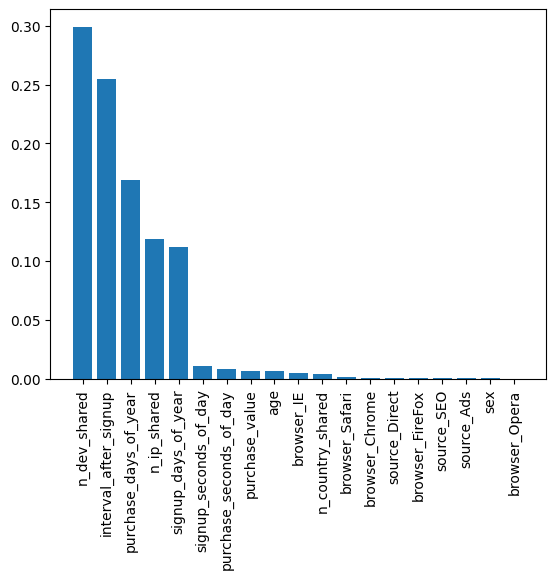

In [ ]:
import matplotlib.pyplot as plt
importances = Best_rf_recall.feature_importances_
feature_name = X_train.columns.values
indices = np.argsort(importances)[::-1]
plt.figure(1)
plt.bar(feature_name[indices[:20]], importances[indices[:20]])
plt.xticks(rotation=90)
plt.show()

It seems that device share and signup time will be an important feature to detect fraud and detect anomaly.

## Fraud characteristics

In [ ]:
trainDF = pd.concat([X_train, y_train], axis=1)
pd.crosstab(trainDF["n_dev_shared"],trainDF["class"])

class,0,1
n_dev_shared,,
0.00,104932,455
0.25,4421,391
0.50,156,189
0.75,38,98
1.00,4,16


In [ ]:
fraud_data.groupby("class")[['interval_after_signup']].mean()

,interval_after_signup
class,
0,5.191179e+06
1,2.570226e+06


In [ ]:
fraud_data.groupby("class")[['interval_after_signup']].median()

,interval_after_signup
class,
0,5194911.0
1,1.0


In [ ]:
probsBest_recall

array([[0.68709795, 0.31290205],
       [0.74786249, 0.25213751],
       [0.71711038, 0.28288962],
       ...,
       [0.69916666, 0.30083334],
       [0.69877655, 0.30122345],
       [0.71287948, 0.28712052]])

In [ ]:
in_10 = (10 * probsBest_recall[:, 1]).astype(int)
unique, counts = np.unique(in_10, return_counts=True)
print(np.asarray((unique, counts)).T)

[[    2 19343]
 [    3  7844]
 [    4    44]
 [    5   153]
 [    6   150]
 [    7     4]
 [    8    52]
 [    9    86]]


According to the evaluation and the tunning, Random forest is the best model in this case to predict anomaly transactions. It is surpricing that the Isolation forest didn't perform very well. And below I will provide a simple threshold for the company to make diferent decisions after detection.


In my opinion, the prediction threshold should be like this:

green: 2 - 4 pass

grey: 5,6 need manual investigation, customer service

red: 7,8,9 decline